In [1]:
#import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from IPython.display import display
from IPython.display import Image as _Imgdis

from skimage.io import imread

np.random.seed(27)

In [2]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [3]:
# get train file paths
train_folder = os.listdir("train")
print("Number of image files in the train dataset:", len(train_folder))

#get test file paths
#test_folder = os.listdir("test")
#print("Number of image files in the test dataset:", len(test_folder))

Number of image files in the train dataset: 104070


Working with 104070 images
Image examples: 
1967f697e.jpg


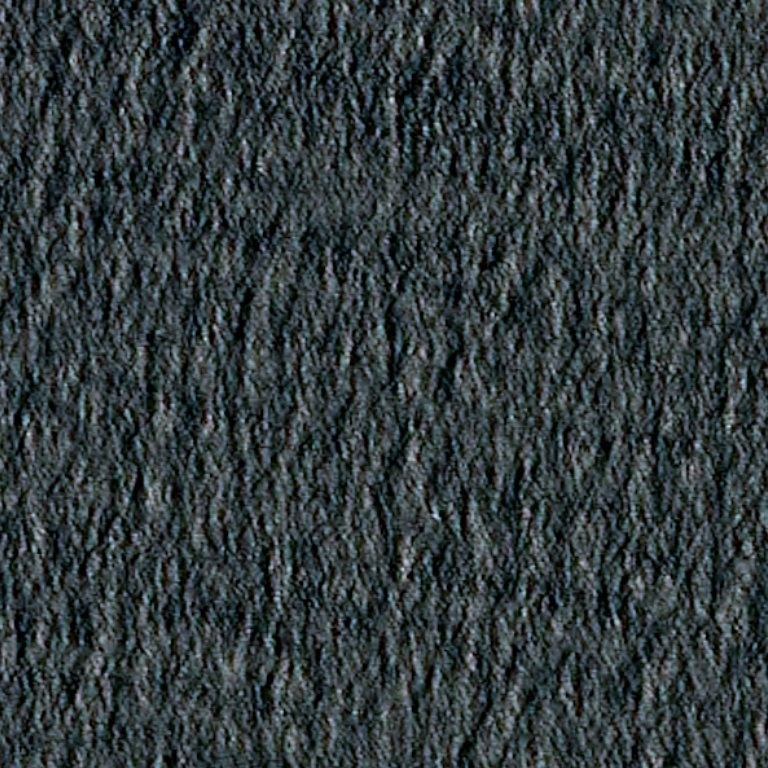

36dcc1323.jpg


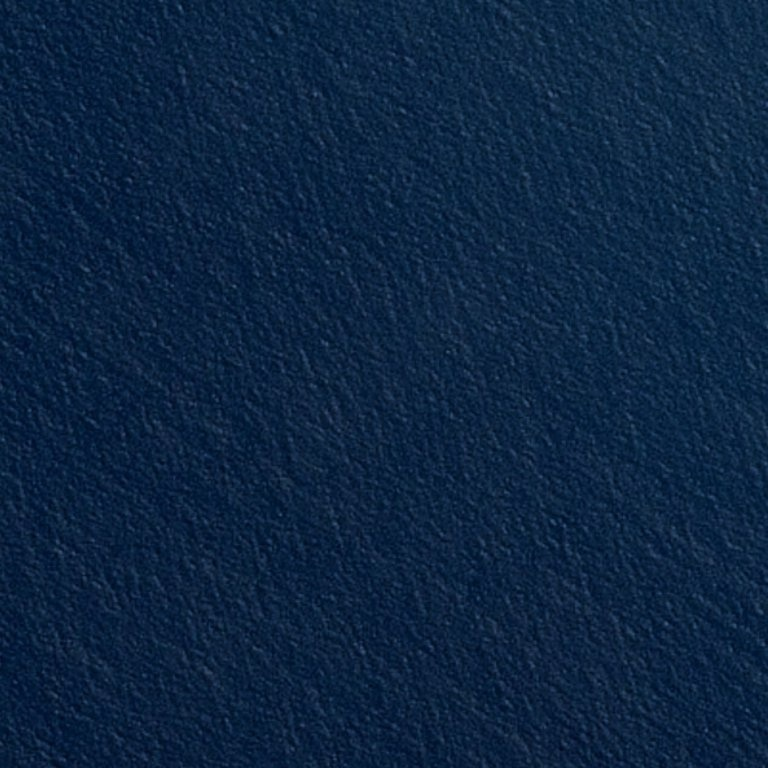

In [4]:
train_folder = 'train'

onlyfiles = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")

for i in range(40, 42):
    print(onlyfiles[i])
    display(_Imgdis(filename=train_folder + "/" + onlyfiles[i], width=240, height=320))

In [5]:
masks = pd.read_csv("train_ship_segmentations.csv", index_col=0)
masks.head()

,EncodedPixels
ImageId,
00003e153.jpg,NaN
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [6]:
masks = masks.reset_index()
masks['ship_count'] = masks.groupby('ImageId')['ImageId'].transform('count')
masks.loc[masks['EncodedPixels'].isnull().values,'ship_count'] = 0

In [7]:
masks.head()

,ImageId,EncodedPixels,ship_count
0,00003e153.jpg,NaN,0
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9


count    131030.000000
mean          1.651378
std           2.999234
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          15.000000
Name: ship_count, dtype: float64


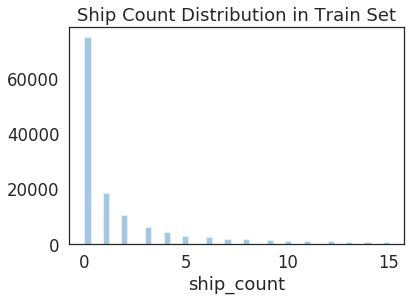

In [8]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.distplot(masks['ship_count'],kde=False)
plt.title('Ship Count Distribution in Train Set')

print(masks['ship_count'].describe())

In [9]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

# ref: https://www.kaggle.com/kmader/baseline-u-net-model-part-1
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# https://github.com/ternaus/TernausNet/blob/master/Example.ipynb
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [10]:
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'images total')
masks.head()

131030 masks found
104070 images total


,ImageId,EncodedPixels,ship_count
0,00003e153.jpg,NaN,0
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9


Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


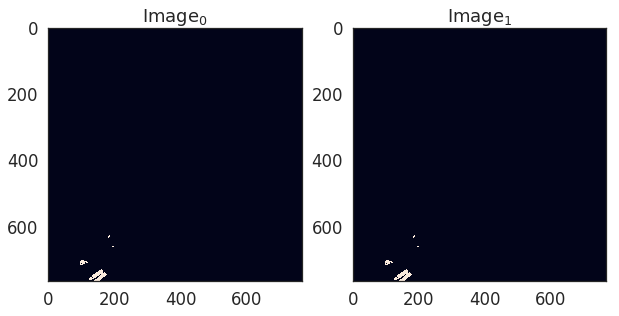

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
2297,058248c2d.jpg,0,0.0,[0.0],190.229492
86824,d5bc51f5a.jpg,0,0.0,[0.0],174.199219
50584,7c593e6cf.jpg,0,0.0,[0.0],110.566406
50840,7cf6d59ad.jpg,0,0.0,[0.0],229.851562
8393,144ce7288.jpg,0,0.0,[0.0],135.798828


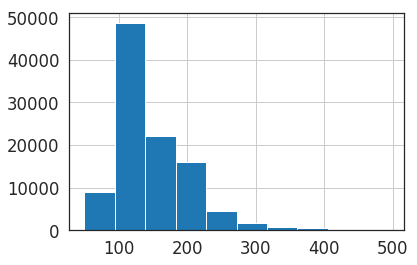

In [12]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_folder, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [13]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

91008 training masks
39006 validation masks


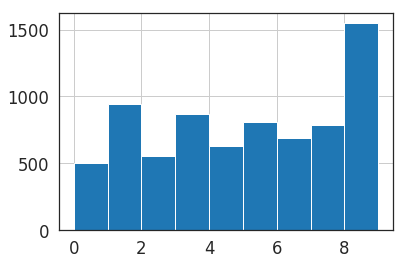

In [14]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [15]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_folder, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [16]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


In [17]:
import cv2
import os

def load_images_from_folder(folder, sample_size):
    images = []
    i = 0
    onlyfiles = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]
    onlyfiles_series = pd.Series(data=onlyfiles).sample(sample_size)
    for filename in onlyfiles_series:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            i += 1
            if i % 1000 == 0:
                print("%d images to array" % i)
    return images

In [18]:
train_images = np.array(load_images_from_folder(train_folder, 100))

In [19]:

m_train = len(train_images)
#m_test = len(test_set_x_orig)
num_px = train_images[0].shape[0]


print ("Number of training examples: m_train = " + str(m_train))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

Number of training examples: m_train = 100
Height/Width of each image: num_px = 768
Each image is of size: (768, 768, 3)


In [20]:
train_images_flat = train_images.reshape(m_train, -1).T

print('train_images_flat shape: ' + str(train_images_flat.shape))
print ("sanity check after reshaping: " + str(train_images_flat[0:5,0]))

train_images_flat shape: (1769472, 100)
sanity check after reshaping: [114 122  82 112 120]


In [21]:
train_images = train_images_flat/255

In [22]:
from sklearn.neural_network import BernoulliRBM

In [23]:
rbm = BernoulliRBM()

rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100


In [24]:
rbm = rbm.fit(train_images)

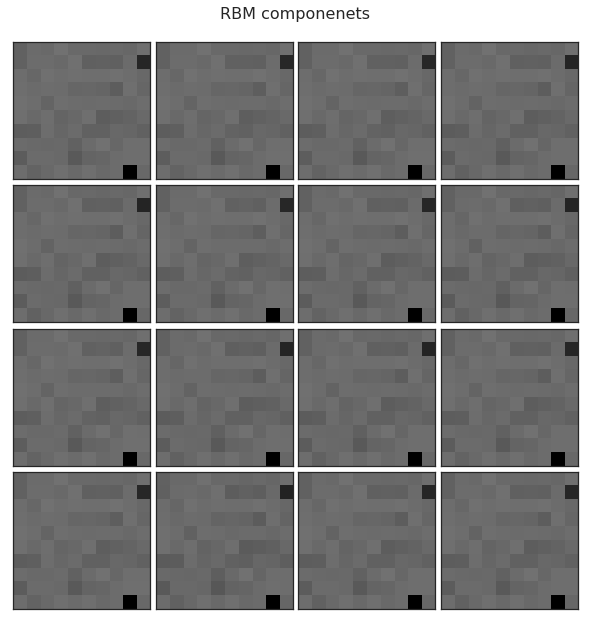

In [25]:
comp = rbm.components_
image_shape = (10, 10)
def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()    
plot_gallery('RBM componenets', comp[:16], 4,4)

In [26]:
plt.close('all')